#TRABAJO PRÁCTICO 2
**Detección de objetos.**
**Integrantes**: Arcagni, Franco e Iglesias Barrera, Ailén.

**Objeto elegido**: escultura precolombina de la cultura Condorhuasi "Suplicantes". Es una figura escultórica que presenta variaciones en su ejecución, pero manteniendo una estructura singular específica. Consideramos que de este modo que sería un objeto interesante para que el modelo tome como nuevo en su entrenamiento ya que si bien hay 3 modelos posibles de tipos de suplicantes los 3 conservan la estructura similar de rostro hacia arriba y forma de prisma.
Se buscaron imágenes de difererentes procedencias, ángulos y color para brindar al modelo la mayor cantidad de información sobre este tipo de esculturas, hay ángulos desde arriba donde se observa la característica del rostro suplicante y diferentes ángulos del volumen.

Consideramos que el modelo logró aprender dentro de lo esperado ya que tomando imágenes que nunca había visto logró una valoración de 0.92 en su identificación. Inclusive tomó de la misma imagen una figura de fondo que se encuentra muy desenfocada, con una valoración correcta de 0.85.

Durante el ejercicio más abajo se puede observar ciertas modificaciones que se hicieron al dataset para obtener un cuerpo robusto dentro de los alcances del trabajo práctico.

# Entrenamiento de una YOLOv11 sobre un corpus propio

---

YOLO11 se basa en los avances introducidos en YOLOv9 y YOLOv10 a principios de este año, incorporando diseños arquitectónicos mejorados, técnicas de extracción de características optimizadas y métodos de entrenamiento perfeccionados.

YOLO11m logra una puntuación mAP media más alta en el conjunto de datos COCO utilizando un 22% menos de parámetros que YOLOv8m, lo que lo hace computacionalmente más ligero sin sacrificar rendimiento.

YOLOv11 está disponible en 5 tamaños diferentes, desde `2.6M` a `56.9M` de parámetros, siendo capaz de obtener desde `39.5` a `54.7` de mAP sobre el dataset COCO.

Revisamos la GPU a la que nos conectamos (si no aparece ninguna, cambiar la máquina virtual del 'Entorno de ejecución')

In [ ]:
!nvidia-smi

Tue Jul  1 23:09:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Instalación de YOLO11 desde Ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/112.6 GB disk)


## Uso out-of-the-box

Vamos a usar el modelo más pequeño para hacer inferencia y que nos dé todas las detecciones de las clases que ya tiene pre-entrenadas (dataset COCO).

Debemos subir una imagen cualquiera a la carpeta raíz y ponerle de nombre 'imagen.jpg'

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/test_suplicantes_01.jpg' save=True

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/test_suplicantes_01.jpg: 640x544 1 dining table, 1 vase, 1 teddy bear, 42.2ms
Speed: 14.5ms preprocess, 42.2ms inference, 318.3ms postprocess per image at shape (1, 3, 640, 544)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


El resultado queda en la carpeta /runs/detect/predict, que va agregando números al final cada vez que hacemos una nueva inferencia, ej: /predict1, /predict2, etc., de manera de no perder los resultados previos.

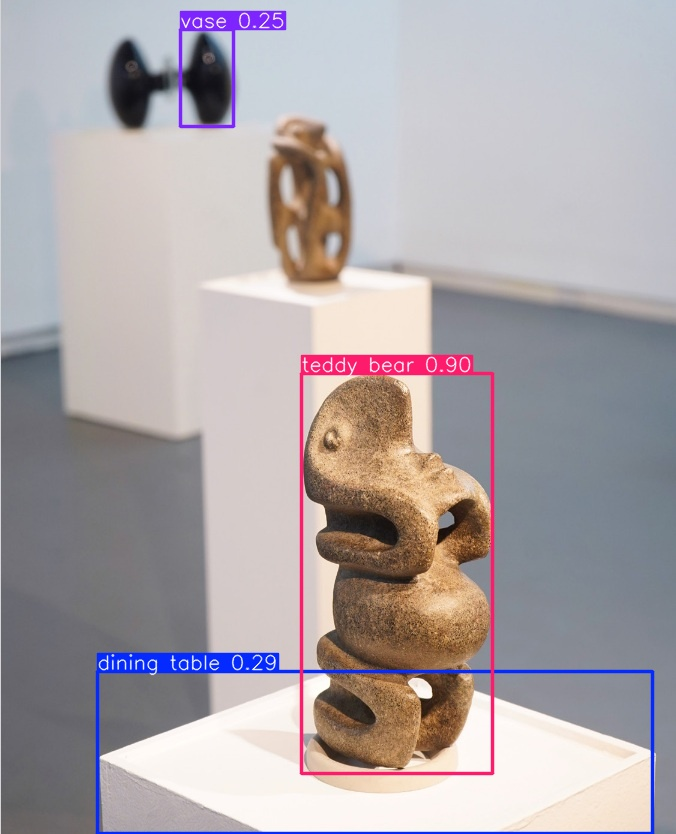

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/test_suplicantes_01.jpg', width=600)

**Sobre una imagen de un suplicante**

Queremos ver ahora cómo se comporta en la detección de un suplicante (clase no presente en el dataset COCO!)

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/suplicantes_22.jpg' save=True

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/suplicantes_22.jpg: 640x448 2 donuts, 46.0ms
Speed: 4.7ms preprocess, 46.0ms inference, 174.7ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


(ACORDARSE! revisar en el log de la inferencia en qué carpeta guardó el resultado, para actualizar la línea siguiente)

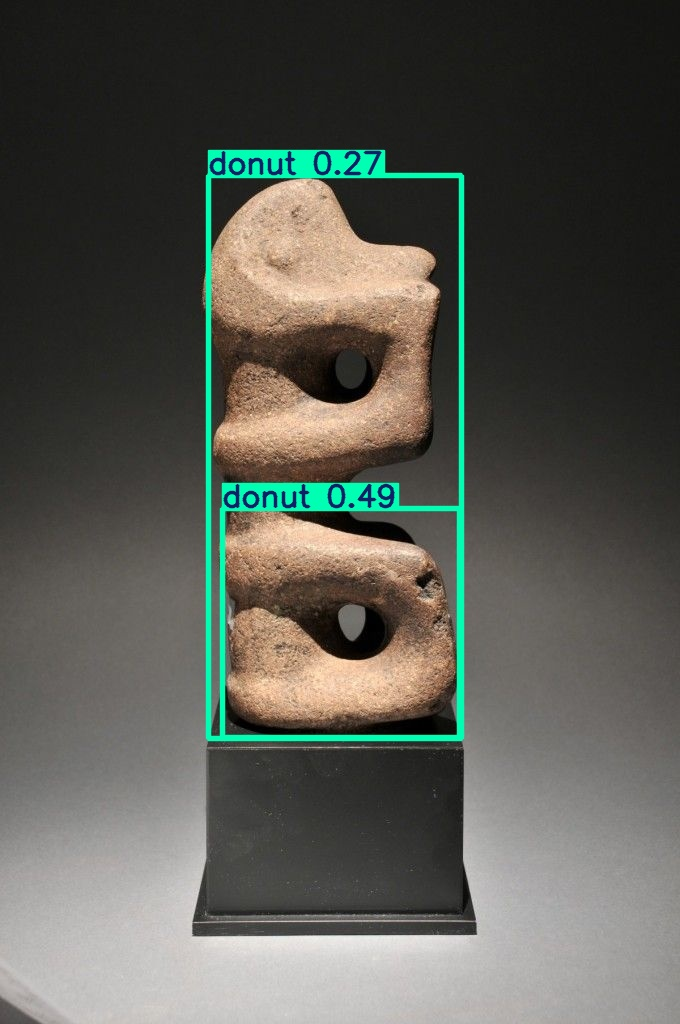

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/predict2/suplicantes_22.jpg', width=600)

## Fine-tuning de una YOLO11 nano sobre el dataset propio

Importamos ahora el dataset generado en Roboflow con las imágenes de suplicantes y con la única clase a detectar 'suplicante'.
Creamos un dataset etiquetado con 28 imágenes y luego le aplicamos la aumentación resultando en un dataset de 68 imágenes, donde se dividió un porcentaje de 88% para train (60 imágenes), 7% para validación (5 imágenes) y 4% para test (3 imágenes).

Se aplicó resize, modificación de hue, saturación, crop, exposure, noise, perspectiva.

In [2]:
!pip install roboflow

from roboflow import Roboflow
from google.colab import userdata

# Obtener la API key de los secretos de Colab
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("tp2-suplicantes").project("tp2_suplicantes")
version = project.version(2)
dataset = version.download("yolov11")

  Using cached roboflow-1.2.11-py3-none-any.whl.metadata (9.7 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached pi_heif-1.1.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.5 kB)
  Using cached pillow_avif_plugin-1.5.2-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.8


Extracting Dataset Version Zip to tp2_suplicantes-2 in yolov11:: 100%|██████████| 147/147 [00:00<00:00, 6667.27it/s]


## Re-entrenamiento

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=1000 imgsz=640 plots=True

#se hicieron dos pruebas, una con 200 épocas inicialmente y otra con 1000 épocas

/content
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tp2_suplicantes-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1000, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

Resultados del entrenamiento (con gráficas de desempeño) en `{HOME}/runs/detect/train/`, vamos a examinarlas.

In [ ]:
!ls {HOME}/runs/detect/train2/

args.yaml			 P_curve.png	   train_batch1.jpg
confusion_matrix_normalized.png  PR_curve.png	   train_batch2.jpg
confusion_matrix.png		 R_curve.png	   val_batch0_labels.jpg
F1_curve.png			 results.csv	   val_batch0_pred.jpg
labels_correlogram.jpg		 results.png	   weights
labels.jpg			 train_batch0.jpg


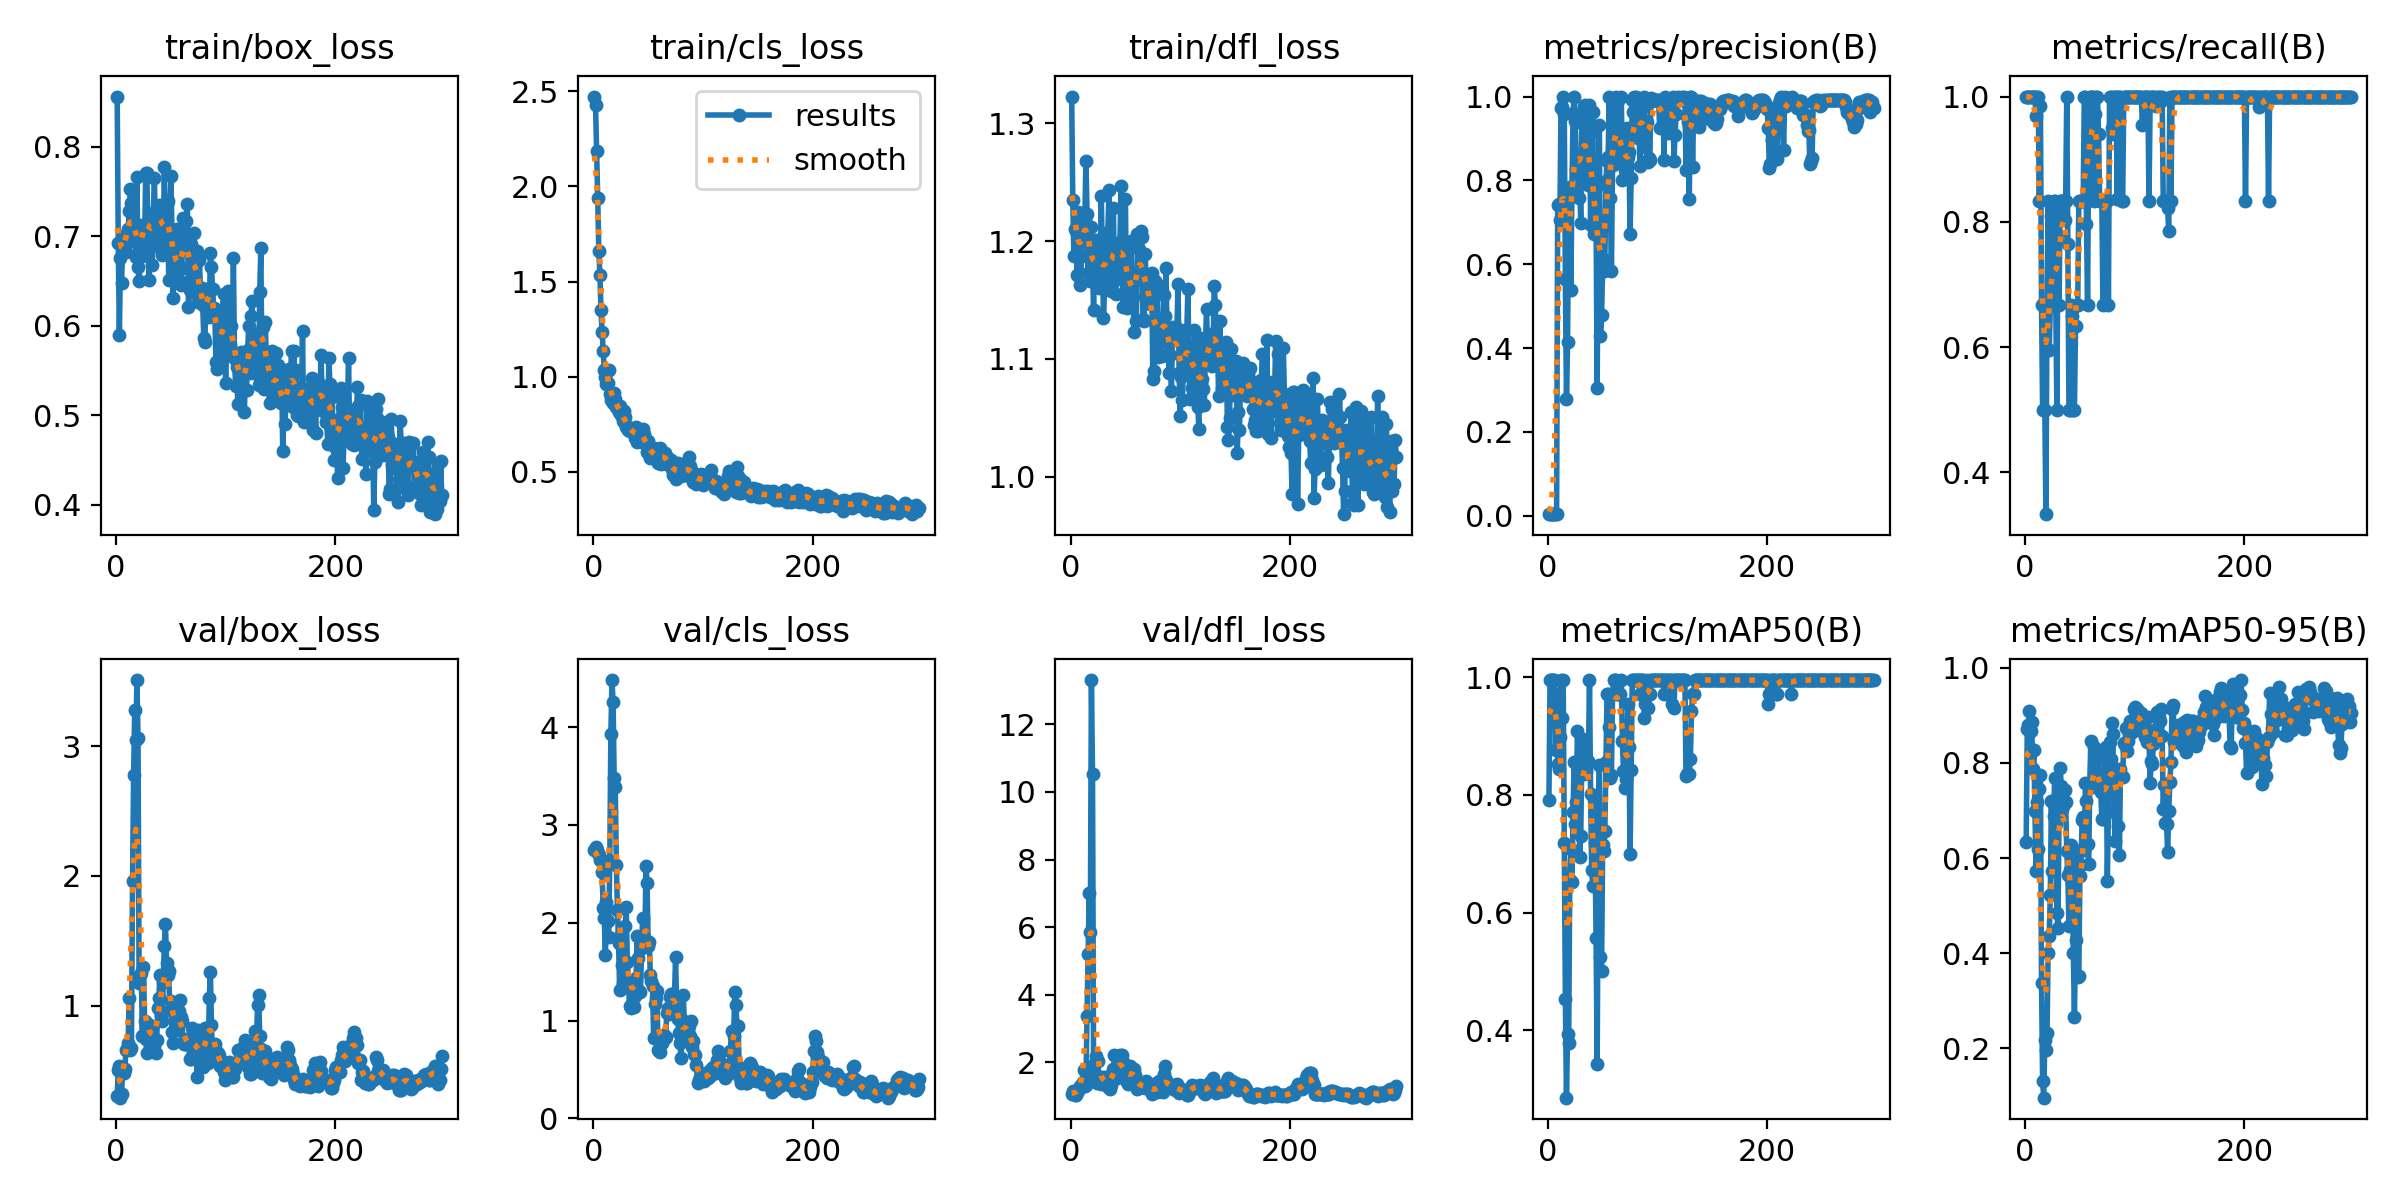

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/results.png', width=800)

Vemos ahora la detección sobre las imágenes de validación.

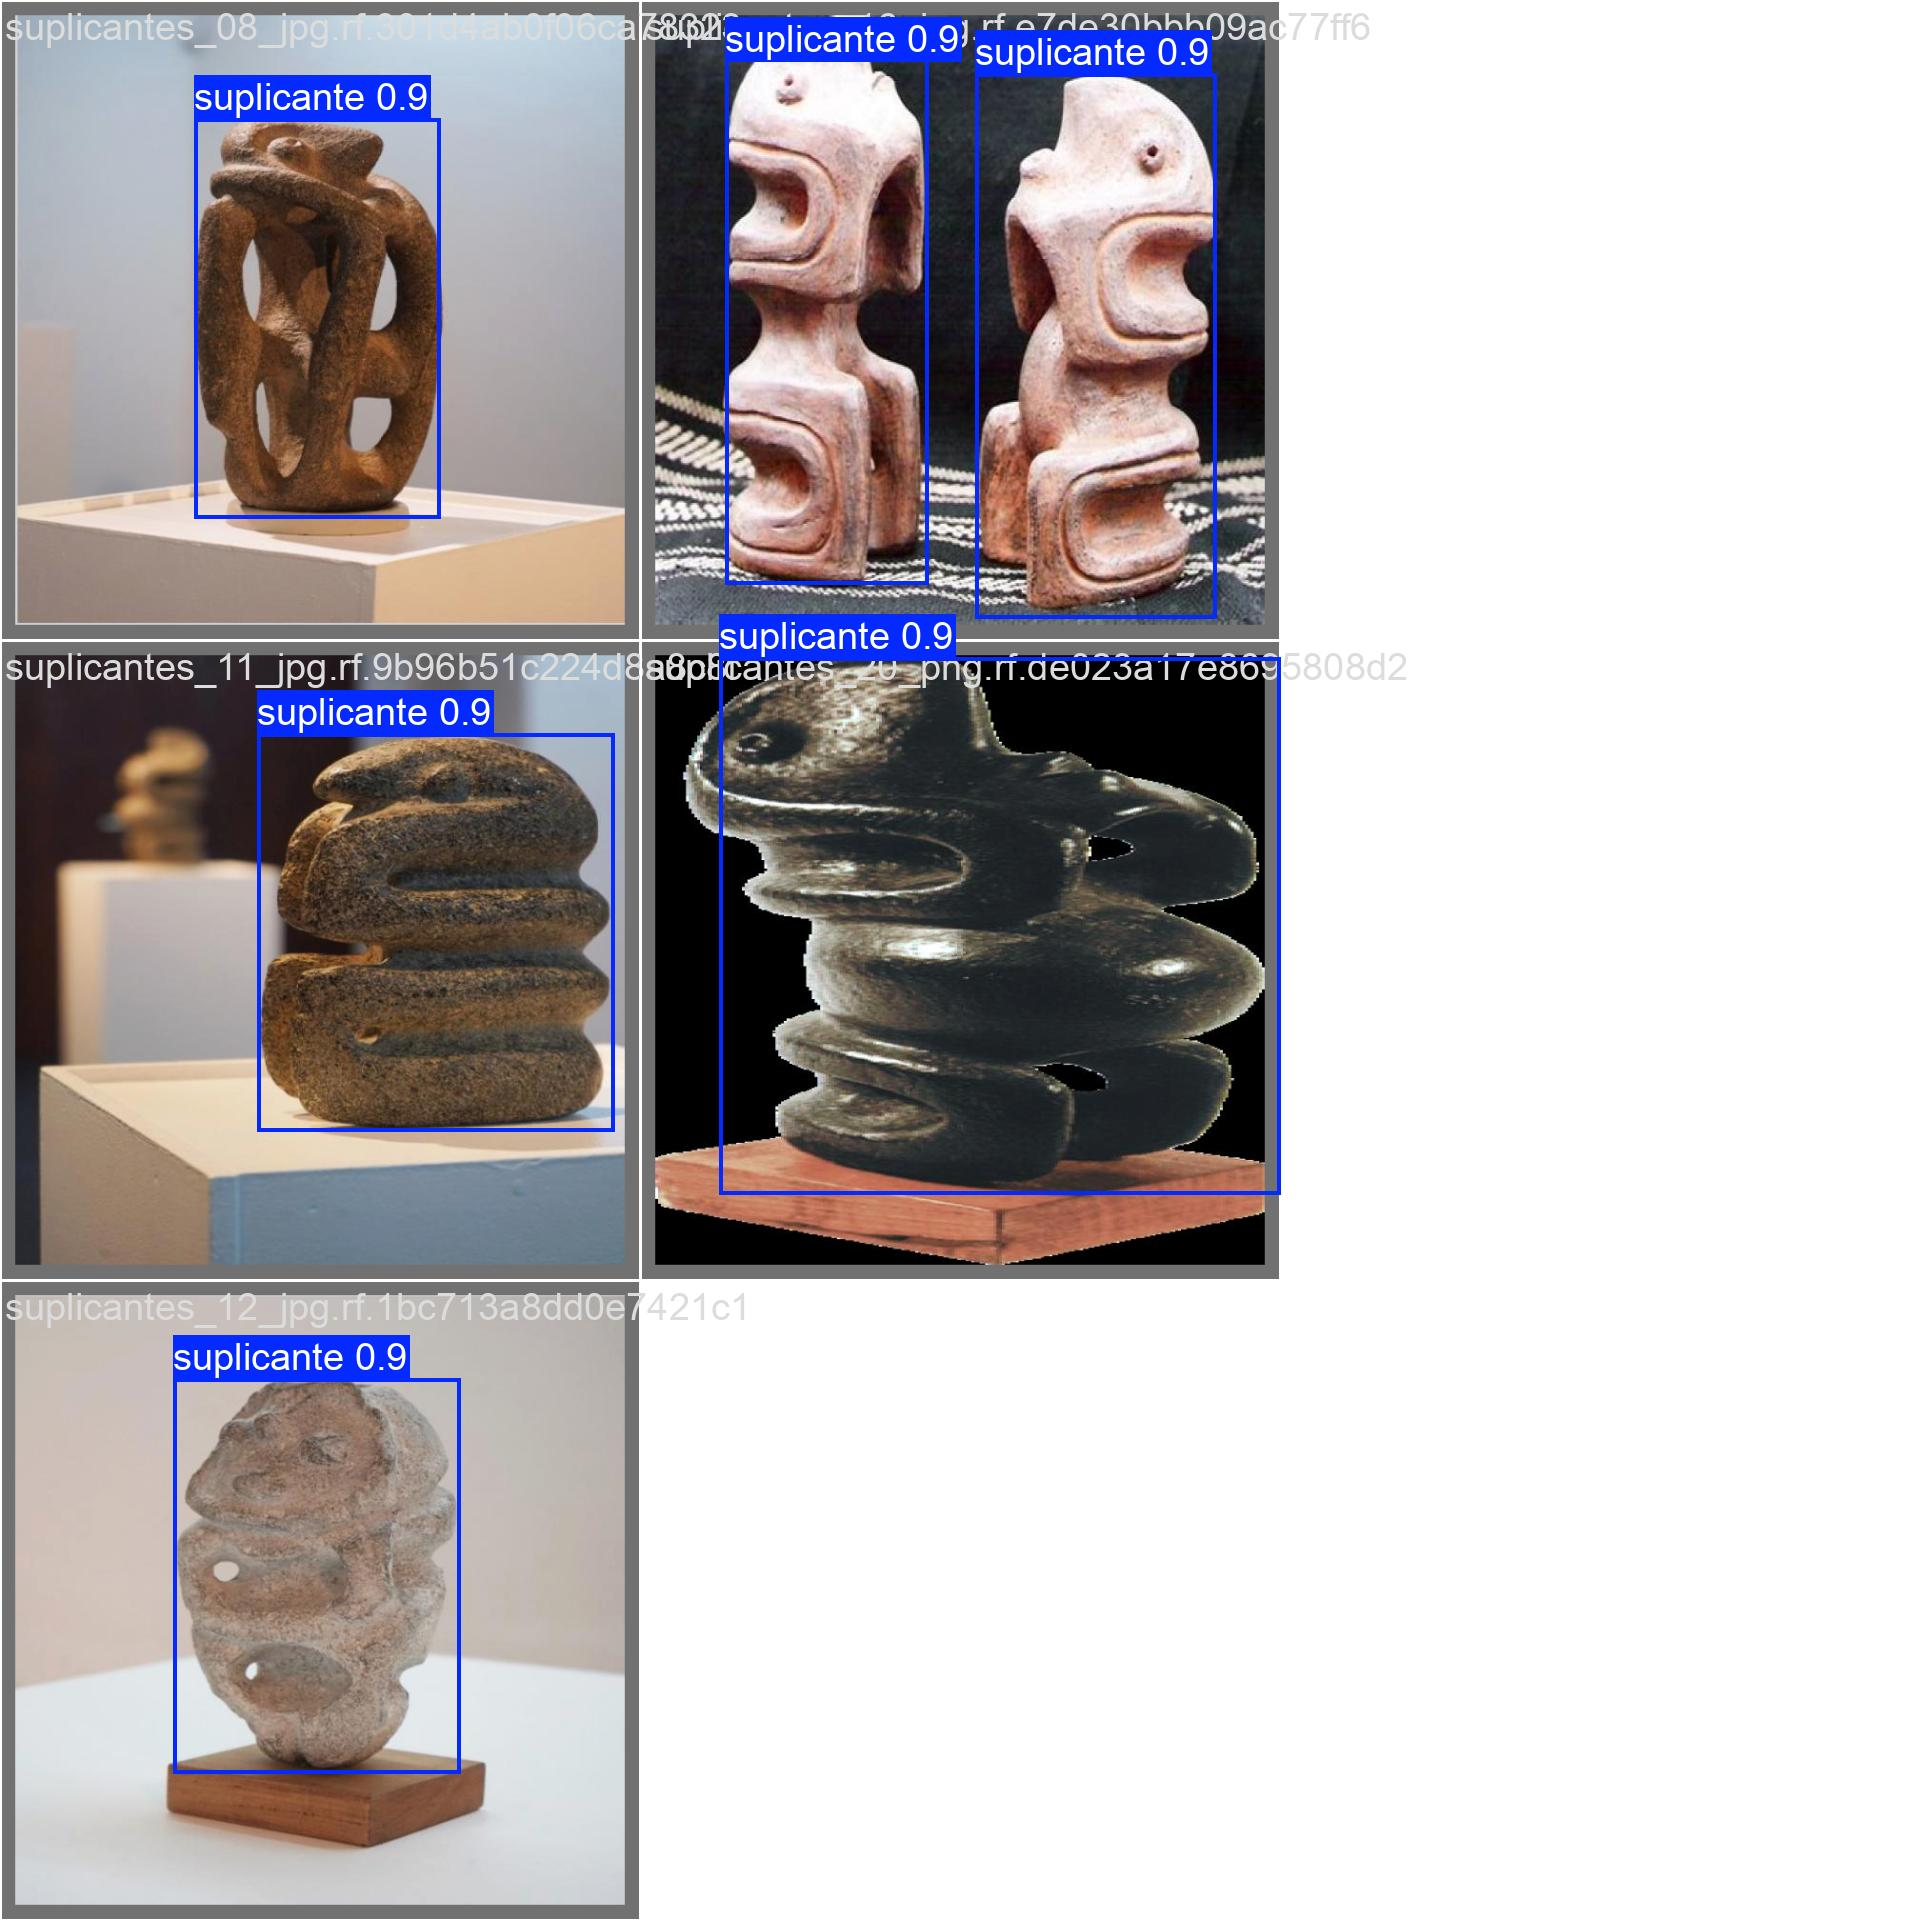

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Inferencia sobre imágenes de test

Corremos ahora la detección sobre las imágenes de test (no vistas en el entrenamiento)

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/3 /content/tp2_suplicantes-2/test/images/suplicantes_04_jpg.rf.3eadd35d152903e0dcbe6eb192b5b58d.jpg: 640x640 1 suplicante, 27.2ms
image 2/3 /content/tp2_suplicantes-2/test/images/suplicantes_05_jpg.rf.69e821cba87f83cc3612872e84d192e9.jpg: 640x640 2 suplicantes, 15.9ms
image 3/3 /content/tp2_suplicantes-2/test/images/suplicantes_09_jpg.rf.3afab9b54dd900d918006388a00208d3.jpg: 640x640 1 suplicante, 14.6ms
Speed: 4.2ms preprocess, 19.2ms inference, 70.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict15
💡 Learn more at https://docs.ultralytics.com/modes/predict


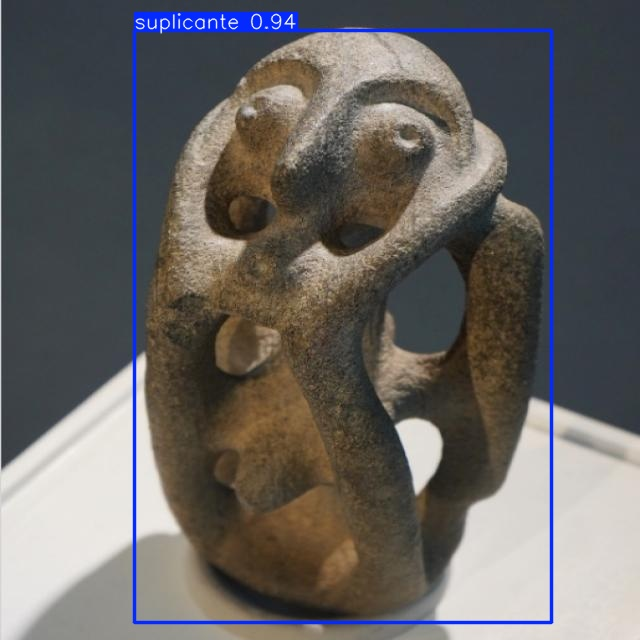

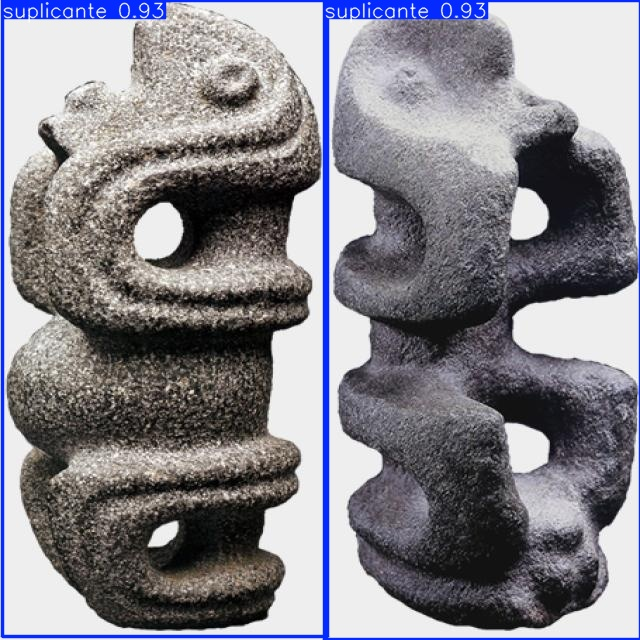

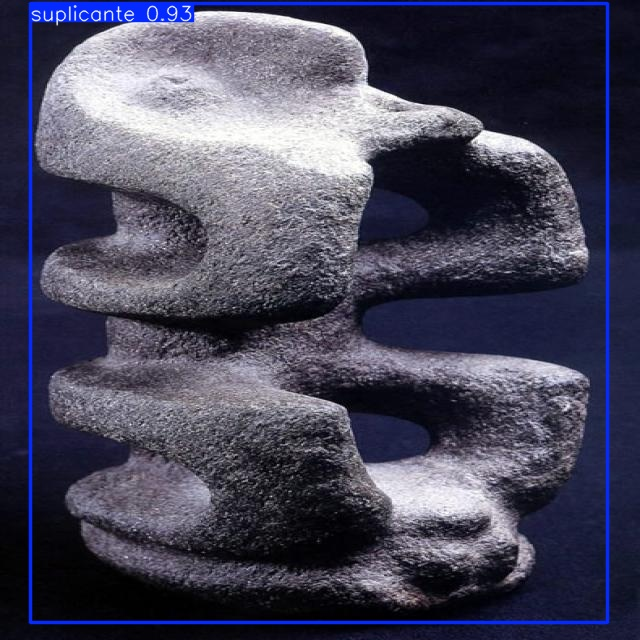

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict15/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Imagen adicional para prueba

Se bajó una imagen nueva en el directorio raíz, y se corrió de nuevo el modelo para hacer inferencia y mostrar resultados.

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /content/test_suplicantes_01.jpg: 640x544 3 suplicantes, 45.9ms
Speed: 3.6ms preprocess, 45.9ms inference, 139.9ms postprocess per image at shape (1, 3, 640, 544)
Results saved to runs/detect/predict14
💡 Learn more at https://docs.ultralytics.com/modes/predict
Results saved to: /content/runs/detect/predict14/


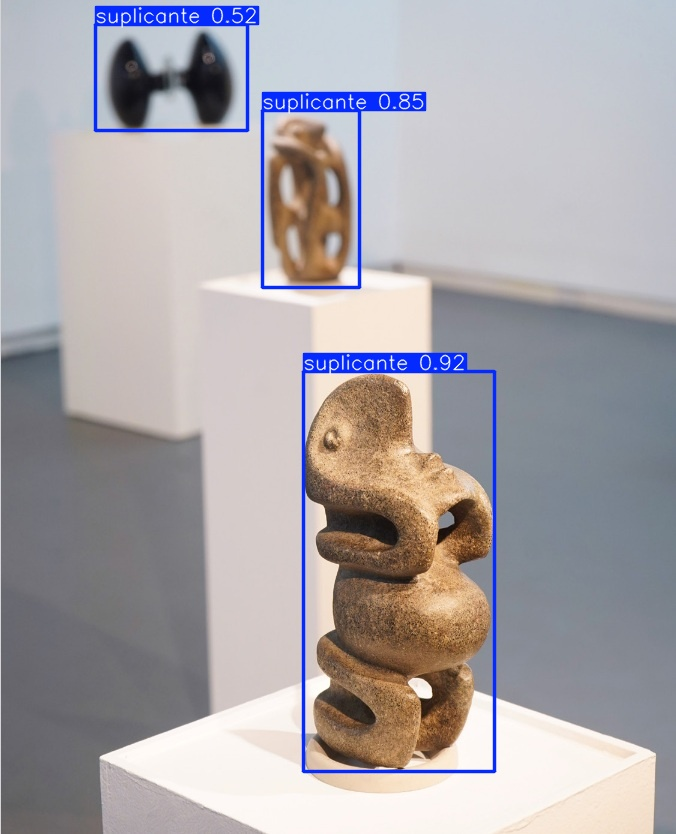

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/test_suplicantes_01.jpg save=True

latest_predict_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
print(f"Results saved to: {latest_predict_folder}")
# Display the results
from IPython.display import Image as IPyImage, display
for img in glob.glob(f'{latest_predict_folder}/*.jpg'):
    display(IPyImage(filename=img, width=600))
    print("\n")